# Nonlinear

## Import modules

In [1]:
# Basic stuff
import sys
sys.path.append("/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/lib/python/")
import genericIO
import SepVector
import Hypercube
import Acoustic_iso_double
import numpy as np
import time

# Plotting library
import matplotlib.pyplot as plt
import sepPlot


## Wavelet

In [43]:
# Generate wavelet 
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/waveletMain.py timeDelay=1.0 f1=2 f2=5 f3=8 f4=15 type=ali par=parNonlinear.p wavelet=waveletNonlinear.H

# Plot wavelet using SEPLib
# !Spectra < wlt.H | Graph grid=y title="Wavelet spectrum" max1=30 label1="Frequency [Hz]" | Xtpen 
# !Graph grid=y max1=2.0 title="Wavelet" < wlt.H | Xtpen 

## Velocity model

In [44]:
# Pad Marmousi velocity model
!/net/server/homes/sep/gbarnier/code/gpu/acousticIsoOp/test/bin/padFileGpuMain zPad=100 xPad=100 model=velocityMarmousi.H data=velocityMarmousi.pad.H

 
------------------------ Model padding program --------------------
Original nz = 350 [samples]
Original nx = 1700 [samples]
 
zPadMinus = 100 [samples]
zPadPlus = 110 [samples]
xPadMinus = 100 [samples]
xPadPlus = 104 [samples]
 
blockSize = 16 [samples]
FAT = 5 [samples]
 
New nz = 570 [samples including padding and FAT]
New nx = 1914 [samples including padding and FAT]
-------------------------------------------------------------------
 


## Initialize nonlinear operator

In [45]:
# Note: You need a "dummy arg" for the first argument to replace what would be the executable
args=["dummy arg","vel=velocityMarmousi.pad.H","model=waveletNonlinear.H","par=parNonlinear.p"]
modelDouble, dataDouble, velDouble, parObject, sourcesVector, receiversVector = Acoustic_iso_double.nonlinearOpInitDouble(args)

# Printing parameter file for reference
!cat parNonlinear.p


nts=1000
dts=0.008
sub=8
nz=570
nx=1914
zPadMinus=100
zPadPlus=110
xPadMinus=100
xPadPlus=104
dz=0.01
dx=0.01
fMax=20
zSource=2
xSource=850
nShot=1
spacingShots=10
depthReceiver=2
nReceiver=1700
dReceiver=1
oReceiver=1
saveWavefield=0
wavefieldShotNumber=0
blockSize=16
fat=5
nGpu=8


## Create nonlinear object

In [46]:
nonlinearOp=Acoustic_iso_double.nonlinearPropShotsGpu(modelDouble,dataDouble,velDouble,parObject,sourcesVector,receiversVector)

## Read model (wavelet)

In [49]:
modelFile=parObject.getString("model")
modelFloat=genericIO.defaultIO.getVector(modelFile,ndims=3)
modelDMat=modelDouble.getNdArray()
modelSMat=modelFloat.getNdArray()
modelDMat[:]=modelSMat

## Nonlinear forward

In [50]:
# Apply nonlinear forward (1 shot)
nonlinearOp.forward(False,modelDouble,dataDouble);


## Nonlinear adjoint

In [51]:
# Create a model vector for adjoint result
modelDoubleAdj=SepVector.getSepVector(modelDouble.getHyper(),storage="dataDouble")

# Apply adjoint
nonlinearOp.adjoint(False,modelDoubleAdj,dataDouble);

## Display results 
help(sepPlot) to access self documention

### Velocity model

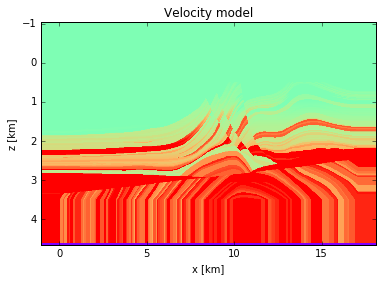

In [59]:
# Plot velocity model
sepPlot.Grey(plt,velDouble,label1="z [km]",label2="x [km]",title="Velocity model",color="J").output()

### Model

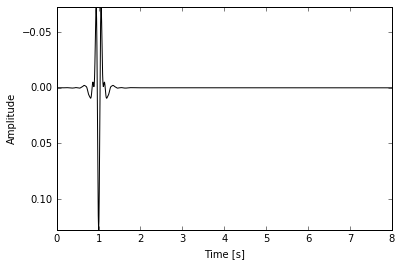

In [61]:
# Convert model to 1D float
modelFloat1D=SepVector.getSepVector(Hypercube.hypercube(axes=[modelDoubleAdj.getHyper().axes[0]]))
modelFloat1DNd=modelFloat1D.getNdArray()
modelDoubleNd=modelDouble.getNdArray()
modelFloat1DNd[:]=modelDoubleNd

# Plot output model after adjoint
sepPlot.Graph(plt,modelFloat1D,label1="Time [s]",label2="Amplitude",title="Adjoint").output()

### Forward

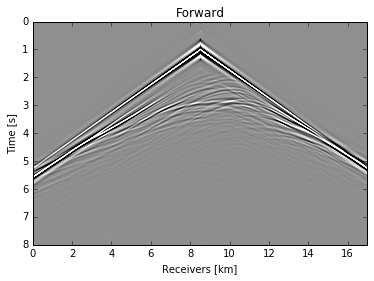

In [38]:
# Convert data to 2D float 
dataFloat2D=SepVector.getSepVector(Hypercube.hypercube(axes=[dataDouble.getHyper().axes[0],dataDouble.getHyper().axes[1]]))
dataFloat2DNd=dataFloat2D.getNdArray()
dataDoubleNd=dataDouble.getNdArray()
dataFloat2DNd[:]=dataDoubleNd

# Plot shot gather
sepPlot.Grey(plt,dataFloat2D,label1="Time [s]",label2="Receivers [km]",title="Forward").output()



### Adjoint

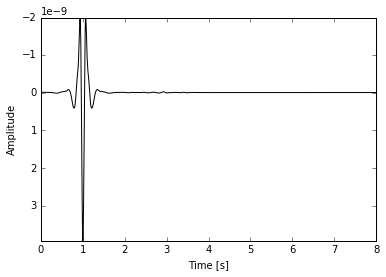

In [39]:
# Convert model to 1D float
adjointFloat1D=SepVector.getSepVector(Hypercube.hypercube(axes=[modelDoubleAdj.getHyper().axes[0]]))
adjointFloat1DNd=adjointFloat1D.getNdArray()
modelDoubleNd=modelDoubleAdj.getNdArray()
adjointFloat1DNd[:]=modelDoubleNd

# Plot output model after adjoint
sepPlot.Graph(plt,adjointFloat1D,label1="Time [s]",label2="Amplitude",title="Adjoint").output()

## Write results to disk

In [40]:
# Data 
dataFloat=SepVector.getSepVector(dataDouble.getHyper(),storage="dataFloat")
dataFloatNp=dataFloat.getNdArray()
dataDoubleNp=dataDouble.getNdArray()
dataFloatNp[:]=dataDoubleNp
_=genericIO.defaultIO.writeVector("nonlinearFwdJupyter.H",modelFloat)

# Model after applying FWD and ADJ
modelFloat=SepVector.getSepVector(modelDoubleAdj.getHyper(),storage="dataFloat")
modelFloatNp=modelDoubleAdj.getNdArray()
modelDoubleNp=modelDoubleAdj.getNdArray()
modelFloatNp[:]=modelDoubleNp
_=genericIO.defaultIO.writeVector("nonlinearAdjJupyter.H",modelFloat)

## Dot product test

In [41]:
nonlinearOp.dotTest(True)

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
	Runs in: 1.2363080978393555 seconds
Applying adjoint operator add=False
	Runs in: 0.9634382724761963 seconds
Dot products add=False: domain=-0.00022738923457866768 range=-0.00022738923457866036 
Absolute error: 7.318364664277155e-18
Relative error: 3.2184305813059614e-14 


Applying forward operator add=True
	Runs in: 1.049471378326416 seconds
Applying adjoint operator add=True
	Runs in: 1.4273133277893066 seconds
Dot products add=True: domain=-0.00045477846915733524 range=-0.0004547784691573192 
Absolute error: 1.6046192152785466e-17
Relative error: 3.5283535261724734e-14 

-------------------------------------------------
